---
### **Notebook 5.0**
#### rot-polar form of the registrated images. 
- input: *.fits
- output: *.fits

STEP 1: file load. 

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from astropy.io import fits
import skimage.io as io 
import struct
import imageio as iio
from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift
import cv2
from PIL import Image

In [21]:
path0 = '/Volumes/WD1T/share/TSE2023/'   
path1 = '/Volumes/WD1T/share/TSE2023/iPhone/result/'    
dirr2t = path1 + 'r2dfdatat/'           # input: registration 2nd

dirpol = path1 + 'pol_rot_r2dfdata/'    # output dir
if not os.path.exists(dirpol ):
    os.makedirs(dirpol )

In [22]:
import os
import glob

# delete ._* files
files_to_delete = glob.glob(os.path.join(dirr2t, '._*'))

for file in files_to_delete:
    try:
        os.remove(file)
        print(f"Deleted: {file}")
    except Exception as e:
        print(f"Error deleting {file}: {e}")

In [23]:
# preview the input dir
pathd = dirr2t 
listd = os.listdir(pathd)
listd.sort()
print(listd[0:10])
print(len(listd))
st = 0
fn = len(listd) - st

['r2_r1_image_00001.fits', 'r2_r1_image_00002.fits', 'r2_r1_image_00003.fits', 'r2_r1_image_00004.fits', 'r2_r1_image_00005.fits', 'r2_r1_image_00006.fits', 'r2_r1_image_00007.fits', 'r2_r1_image_00008.fits', 'r2_r1_image_00009.fits', 'r2_r1_image_00010.fits']
13282


---
### **Notebook 5.0**
#### rot-polar form of the registrated images. 

STEP 2: rotation of the img, and then transfer to the polar form
- find the rotation center

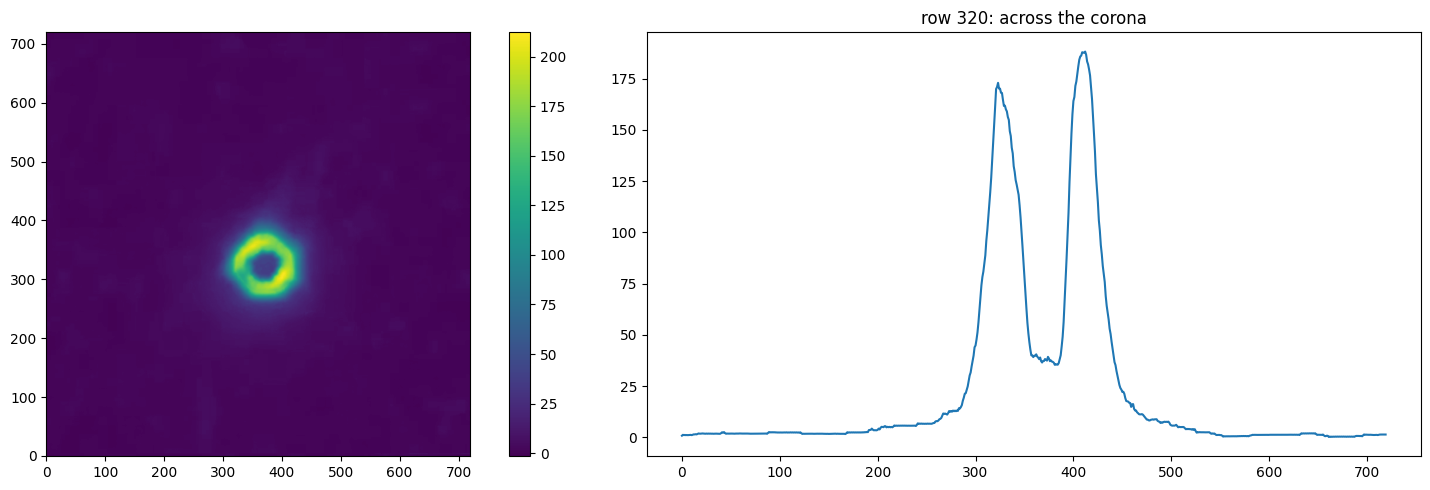

In [24]:
hdu2 = fits.open(pathd + listd[st + 3000])
img2 = hdu2[0].data

imgtmp = img2.copy()
img = imgtmp[:, 280:280+720]

plt.figure(figsize = [16,5])
plt.subplot(121)
plt.imshow(img, origin='lower')
plt.colorbar()
plt.subplot(122)
plt.plot(img[320,:])
plt.title('row 320: across the corona')
plt.tight_layout()
plt.show()

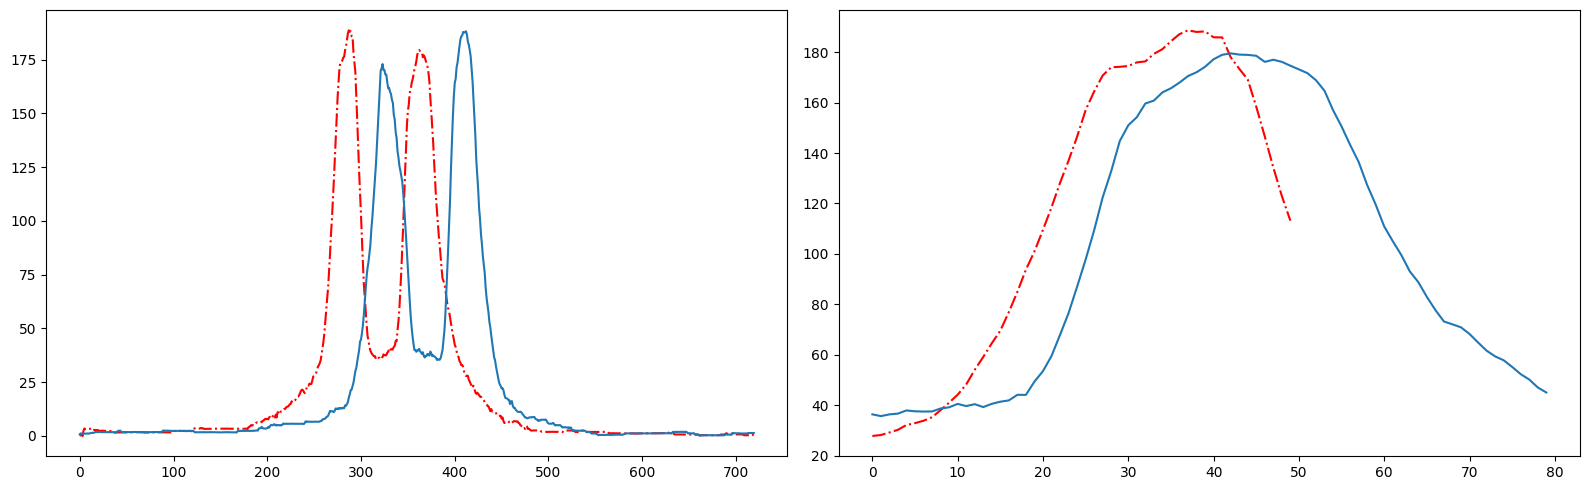

In [25]:
plt.figure(figsize = [16,5])
plt.subplot(121)
plt.plot(img[:,380],'r-.')
plt.plot(img[320,:])

plt.subplot(122)
plt.plot(img[250:300,380],'r-.')
plt.plot(img[320:400,380])
plt.tight_layout()
plt.show()

In [26]:
r1i = np.argmax(img[250:300,380]) + 250 # row 1st index
r2i = np.argmax(img[320:400,380]) + 320
rci = int((r1i + r2i) / 2)
print(r1i, r2i, rci)

287 362 324


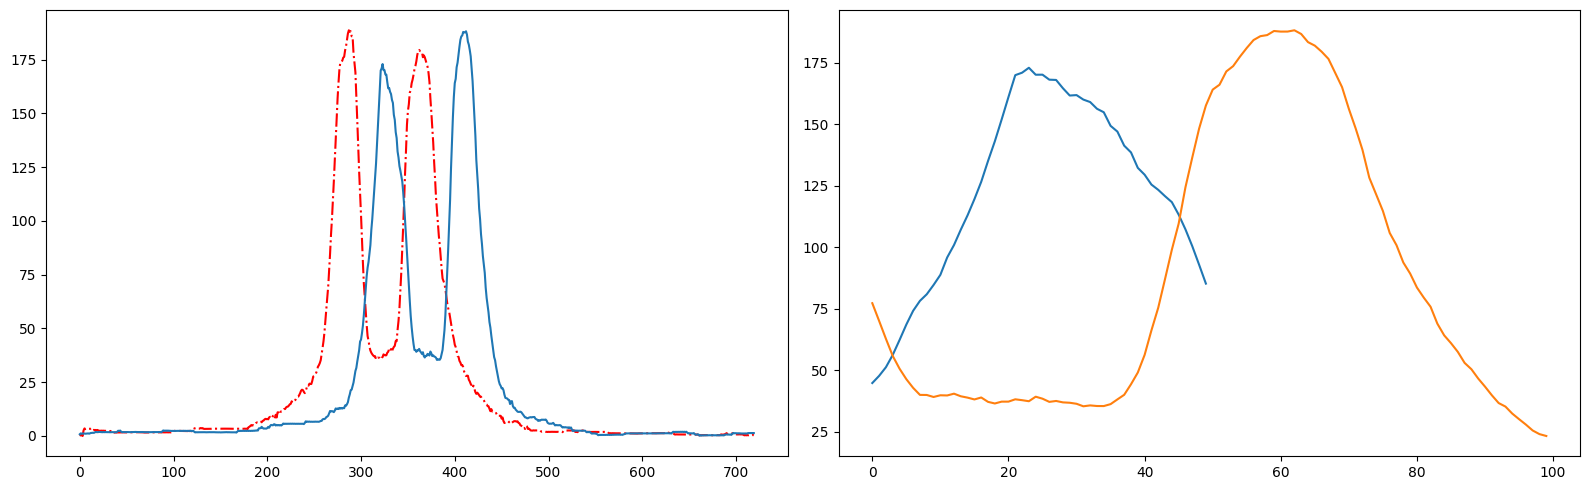

In [27]:
plt.figure(figsize = [16,5])
plt.subplot(121)
plt.plot(img[:,380],'r-.')
plt.plot(img[320,:])

plt.subplot(122)
plt.plot(img[320,300:350])
plt.plot(img[320,350:450])
plt.tight_layout()
plt.show()

In [28]:
c1i = np.argmax(img[320,300:350]) + 300 # row 1st index
c2i = np.argmax(img[320,350:450]) + 350
cci = int((c1i + c2i) / 2)
print(c1i, c2i, cci)

323 412 367


In [29]:
cr, cc = rci, cci + 280  # The 280 shows the cut pixels along the column
sr0, er0, sc0, ec0 = 0, 2*cr, cc- cr, cc + cr
print('rotation center, radial piexles:',cr, cc, cr, 'the cut pixel is:', sr0, er0, sc0, ec0)

rotation center, radial piexles: 324 647 324 the cut pixel is: 0 648 323 971


frame 3000 loaded.


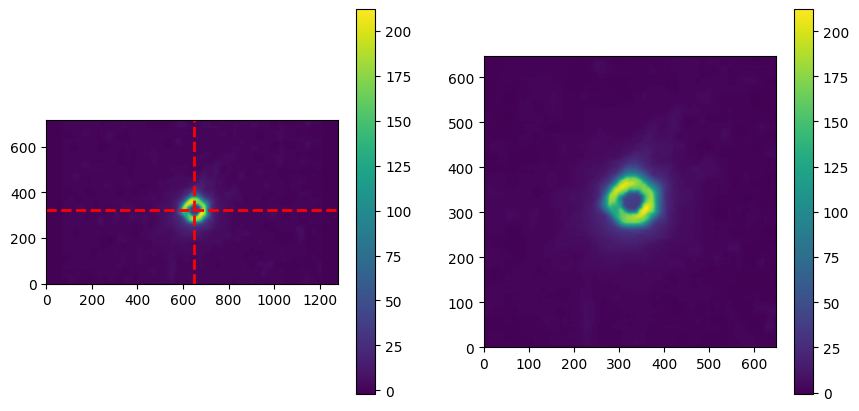

In [30]:
for i in range(3000,3001):
    hdu = fits.open(pathd + listd[st + i])
    print('frame', i, 'loaded.')  
    img = hdu[0].data
    cimg = img[sr0:er0,sc0:ec0]
plt.figure(figsize = [16,5],num = 'img, rimg, pimg')
plt.subplot(131)
plt.imshow(img, origin = 'lower')
plt.axhline(y=cr, color='r', linestyle='--', linewidth=2)
plt.axvline(x=cc, color='r', linestyle='--', linewidth=2)
plt.colorbar()
plt.subplot(132)
plt.imshow(cimg, origin = 'lower')
plt.colorbar()

---
### **Notebook 5.0**
#### rot-polar form of the registrated images. 
- input: *.fits
- output: *.fits

STEP 2: rotation of the img, and then transfer to the polar form
- Define the rotation function and the polar form function

In [31]:
def rotimg(img2, cr, cc):
    img2 = img2 + 10
    # sr, er, sc, ec = 160, 280, 180, 300
    # u, l, le, ri = 33 + sr, 98 + sr, 165, 331
    # cc, cr = int((u + l)/2), int((le + ri)/2)
    sxy = 1  # Scaling factor
    rxy = 10  # Rotation angle required for visual alignment
    rxy = -30  # Rotation angle required for visual alignment
    r1 = cr  # Row center for visual alignment
    r2 = cc  # Column center for visual alignment
    m, n = img2.shape
    matrix = cv2.getRotationMatrix2D((cr, cc), rxy, sxy)
    rimg2 = cv2.warpAffine(img2, matrix, (m, n))
    rimg2 = rimg2.astype('float32')
    return rimg2

import math

def hstackpolar(img):
    m, n = img.shape
    img1 = np.zeros([m, n])
    for i in range(m):
        iml1 = img[i, 0:270]
        iml2 = img[i, 270:361]
        iml = np.concatenate((iml2, iml1), axis=0)
        img1[i, :] = iml
    return img1

# def polarimg(img, cr, cc):
#     csv = int(361/2)
#     csv1 = 500 - 361
#     # sr, er, sc, ec = 160, 280, 180, 300
#     # u, l, le, ri = 33 + sr, 98 + sr, 165, 331
#     # cc, cr = int((u + l)/2), int((le + ri)/2)
#     centy = cc - (csv1)
#     centx = cr - (csv1)
#     radius = cr
#     img = img[cc - csv: cc + csv + 1, cr - csv: cr + csv + 1]
#     img = img.astype('float32')
#     h, w = img.shape
#     centy = csv
#     centx = csv
#     cx, cy = csv + 1, csv + 1
#     #print('cx, cy are:', cx, cy)
#     dim = (w, h)
#     maxRadius = math.hypot(radius, radius)
#     out = cv2.linearPolar(img, (centx, centy), maxRadius, cv2.WARP_FILL_OUTLIERS + cv2.INTER_LINEAR)
#     tout = np.transpose(out)
#     ftout = cv2.flip(tout, 1)
#     htout = hstackpolar(ftout)
#     htout = htout.astype('float32')
#     return(htout)

def cartesian_to_polar(img):
    """
    Converts a Cartesian image to its polar representation.

    Parameters:
    - img: 2D numpy array, the input image in Cartesian coordinates.

    Returns:
    - polar_img: 2D numpy array, the image in polar coordinates.
    """
    h, w = img.shape
    center = (w // 2, h // 2)  # Center of the image (x, y)

    # Maximum radius (from the center to the corner)
    # max_radius = int(np.sqrt((w / 2) ** 2 + (h / 2) ** 2))
    max_radius = int(h / 2)

    # Perform the linear polar transform
    polar_img = cv2.linearPolar(
        img,
        center,
        max_radius,
        cv2.WARP_FILL_OUTLIERS + cv2.INTER_LINEAR
    )

    # Scale the radius to fit within the image height
    polar_img = cv2.resize(polar_img, (int(h / 2), 360))  # 360 for degrees, h for radius

    # Correct the orientation (transpose axes)
    polar_img = np.transpose(polar_img)

    return polar_img


In [32]:
fn,listd[st]

(13282, 'r2_r1_image_00001.fits')

---
### **Notebook 5.0**
#### rot-polar form of the registrated images. 
STEP 2: rotation of the img, and then transfer to the polar form

In [ ]:
st1 = st + 0
hdu = fits.open(pathd + listd[st1])
img = hdu[0].data
img = img[sr0:er0,sc0:ec0]

hdu2 = fits.open(pathd + listd[st + 3000])
img2 = hdu2[0].data
img2 = img2[sr0:er0,sc0:ec0]

hdu3 = fits.open(pathd + listd[st + 3282])
img3 = hdu3[0].data
img3 = img3[sr0:er0,sc0:ec0]
print('reged img.shape, rc, cc',img.shape,cr, cc)
    
for i in range(fn):
    hdu = fits.open(pathd + listd[st + i])
    print('frame', i,listd[st + i], 'loaded.')  
    img = hdu[0].data
    cimg = img[sr0:er0,sc0:ec0]
    rimg = rotimg(cimg, cr, cr)
    pimg = cartesian_to_polar(rimg)
    # hdu1 = fits.PrimaryHDU()
    # hdu1.data = rimg
    # new_hdu = fits.HDUList([hdu1])
    # nname = 'rot_' + listd[st + i]         # nname: new name
    # new_hdu.writeto(dirrot + nname, overwrite=True) 
    pimg = pimg.astype('float32')
    hdu2 = fits.PrimaryHDU()
    hdu2.data = pimg
    new_hdu2 = fits.HDUList([hdu2])
    nname = 'pol_rot_' + listd[st + i]         # nname: new name
    new_hdu2.writeto(dirpol + nname, overwrite=True) 

# plt.figure(figsize=[16,5],num = 'img, rimg, pimg')
# plt.subplot(131)
# plt.imshow(img, origin = 'lower')
# plt.title('Registration 2nd (last frame)')
# plt.colorbar()
# plt.subplot(132)
# plt.imshow(rimg, origin = 'lower')
# plt.title('Rotation the ROI')
# plt.colorbar()
# plt.subplot(133)
# plt.imshow(pimg, origin = 'lower')
# plt.axhline(y=143, color='r', linestyle='--', linewidth=2)
# # plt.axhline(y=158, color='r', linestyle='--', linewidth=2)
# plt.title('Polar form (redline: 4.5 $R_{\odot}$)')
# plt.colorbar()
# plt.tight_layout()

reged img.shape, rc, cc (648, 648) 324 647
frame 0 r2_r1_image_00001.fits loaded.
frame 1 r2_r1_image_00002.fits loaded.
frame 2 r2_r1_image_00003.fits loaded.
frame 3 r2_r1_image_00004.fits loaded.
frame 4 r2_r1_image_00005.fits loaded.
frame 5 r2_r1_image_00006.fits loaded.
frame 6 r2_r1_image_00007.fits loaded.
frame 7 r2_r1_image_00008.fits loaded.
frame 8 r2_r1_image_00009.fits loaded.
frame 9 r2_r1_image_00010.fits loaded.
frame 10 r2_r1_image_00011.fits loaded.
frame 11 r2_r1_image_00012.fits loaded.
frame 12 r2_r1_image_00013.fits loaded.
frame 13 r2_r1_image_00014.fits loaded.
frame 14 r2_r1_image_00015.fits loaded.
frame 15 r2_r1_image_00016.fits loaded.
frame 16 r2_r1_image_00017.fits loaded.
frame 17 r2_r1_image_00018.fits loaded.
frame 18 r2_r1_image_00019.fits loaded.
frame 19 r2_r1_image_00020.fits loaded.
frame 20 r2_r1_image_00021.fits loaded.
frame 21 r2_r1_image_00022.fits loaded.
frame 22 r2_r1_image_00023.fits loaded.
frame 23 r2_r1_image_00024.fits loaded.
frame 2

In [34]:
img.shape, rimg.shape, pimg.shape

((720, 1280), (648, 648), (324, 360))

---
### **Notebook 5.0**
#### rot-polar form of the registrated images. 

STEP 3: display the rotation and polar form result

37 36


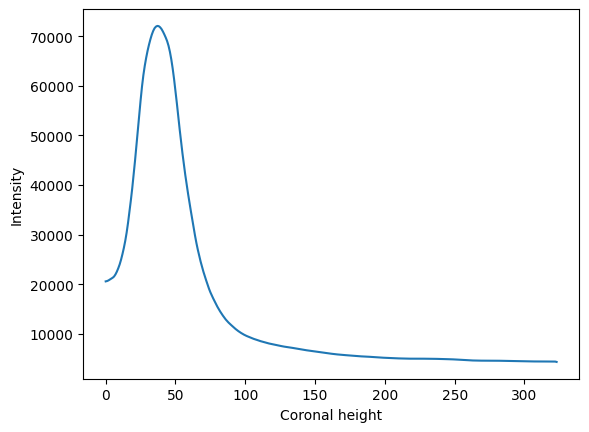

In [35]:
m,n = pimg.shape
rp = np.sum(pimg,axis=1)
plt.plot(rp)
plt.xlabel('Coronal height')
plt.ylabel('Intensity')
ridx = np.argmax(rp[0:100])
r0 = int(ridx/1.006)
print(ridx,r0)

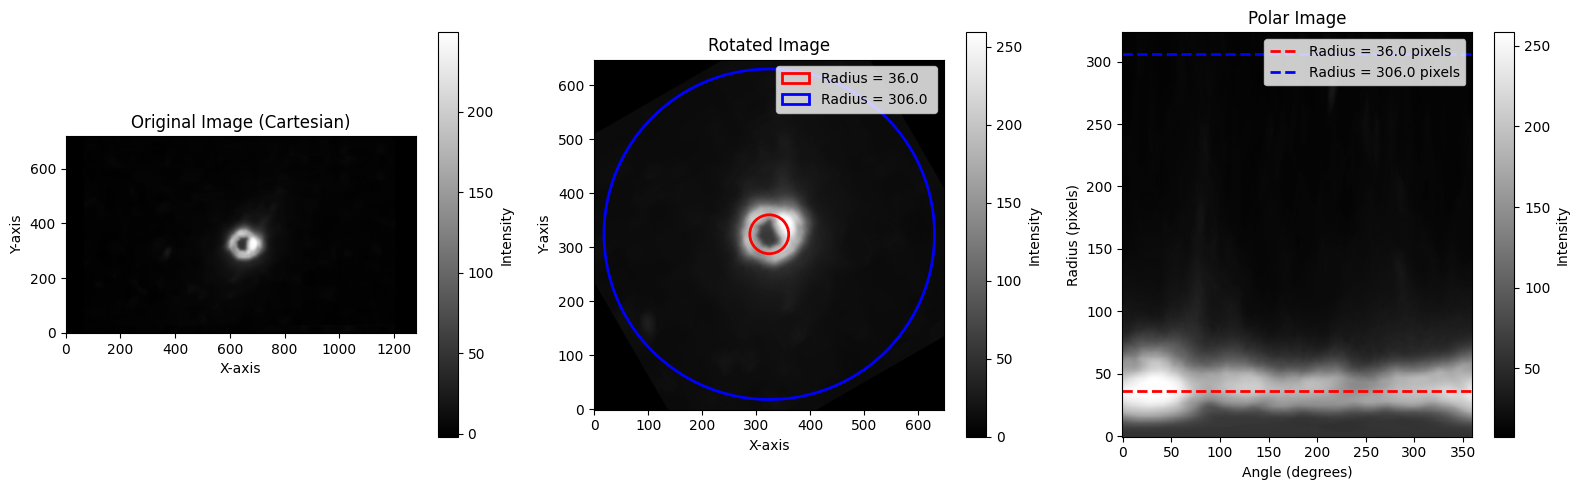

In [36]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

plt.figure(figsize=[16, 5], num='Comparison: Cartesian, Rotated, Polar')
# Display original image
plt.subplot(131)
plt.imshow(img, origin='lower', cmap='gray')
plt.title('Original Image (Cartesian)')
plt.colorbar(label='Intensity')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display rotated image and draw circles
plt.subplot(132)
plt.imshow(rimg, origin='lower', cmap='gray')
plt.title('Rotated Image')
plt.colorbar(label='Intensity')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add circles to the rotated image
circle1 = Circle((rimg.shape[1] // 2, rimg.shape[0] // 2), r0, color='r', fill=False, linewidth=2, label=f'Radius = {int(1 * r0):.1f}')
circle2 = Circle((rimg.shape[1] // 2, rimg.shape[0] // 2), int(8.5 * r0), color='b', fill=False, linewidth=2, label=f'Radius = {int(8.5 * r0):.1f} ')
plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)
plt.legend(loc='upper right')

# Display polar image with red line
plt.subplot(133)
plt.imshow(pimg, origin='lower', cmap='gray', aspect='auto')
plt.axhline(y=r0, color='r', linestyle='--', linewidth=2, label=f'Radius = {1 * r0:.1f} pixels')
plt.axhline(y=8.5*r0, color='b', linestyle='--', linewidth=2, label=f'Radius = {int(8.5 * r0):.1f} pixels')
plt.title('Polar Image')
plt.colorbar(label='Intensity')
plt.xlabel('Angle (degrees)')
plt.ylabel('Radius (pixels)')
plt.legend(loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()


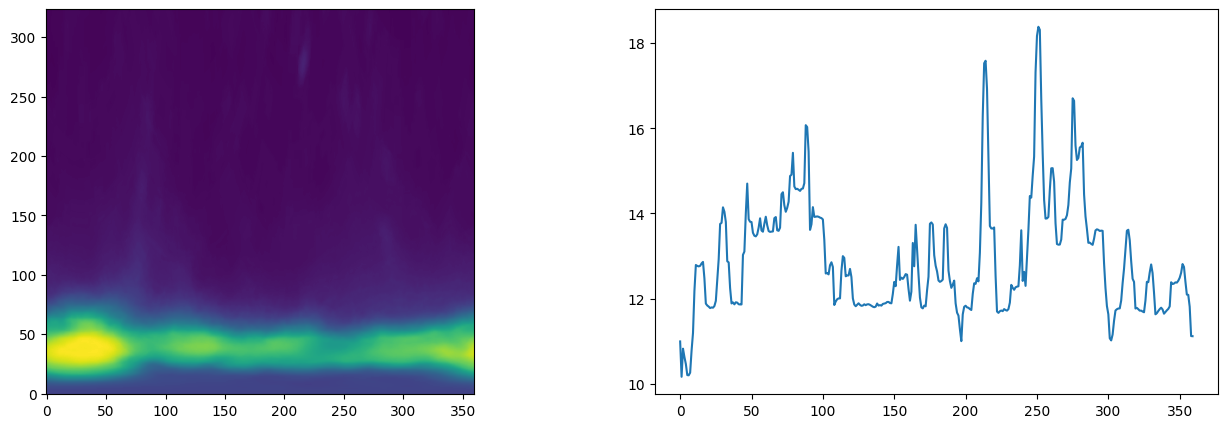

In [37]:
plt.figure(figsize=[16,5])
plt.subplot(121)
plt.imshow(pimg,origin='lower')
plt.subplot(122)
plt.plot(pimg[260])